## Figure 1. Functional landscape of ABL N-Lobe 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, pickle, multiprocessing, time
from collections import defaultdict
from collections import Counter
import itertools 
import subprocess
%matplotlib inline
from pydeseq2.dds import DeseqDataSet
from pydeseq2.dds import DefaultInference
from pydeseq2.ds import DeseqStats
from collections import Counter
from scipy.stats import fisher_exact
from scipy.optimize import curve_fit
from scipy import special as sp
from scipy.integrate import quad
from scipy.optimize import minimize 
from scipy.stats import pearsonr
import math

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
ABL_DMS = pd.read_csv('BCR-ABL DMS Screen.csv')
ABL_DMS['Count_Sum'] = ABL_DMS[['ct_screen1_before', 'ct_screen2_before', 'ct_screen1_after', 'ct_screen2_after' ]].sum(1)

In [3]:
ABL_DMS

,ref_aa,protein_start,alt_aa,species,consequence_terms,ref_codon,alt_codon,ct_screen1_before,ct_screen1_after,ct_screen2_before,ct_screen2_after,Count_Sum
0,A,269,P,A269P,missense_variant,GCC,CCT,12,8,51,13,84
1,A,269,G,A269G,missense_variant,GCC,GGT,12,1,61,0,74
2,A,269,Y,A269Y,missense_variant,GCC,TAC,8,3,35,2,48
3,A,269,W,A269W,missense_variant,GCC,TGG,2,0,32,0,34
4,A,269,F,A269F,missense_variant,GCC,TTC,6,0,48,0,54
...,...,...,...,...,...,...,...,...,...,...,...,...
1475,Y,320,C,Y320C,missense_variant,TAC,TGC,7,90,34,117,248
1476,Y,320,E,Y320E,missense_variant,TAC,GAG,0,0,4,11,15
1477,Y,320,D,Y320D,missense_variant,TAC,GAT,2,21,19,19,61
1478,Y,320,K,Y320K,missense_variant,TAC,AAG,0,0,3,11,14


In [4]:
ABL_DMS_counts = ABL_DMS[['species', 'ct_screen1_before', 'ct_screen2_before', 'ct_screen1_after', 'ct_screen2_after' ]]
ABL_DMS_counts.columns = ['mut', 'D0Rep1', 'D0Rep2', 'D6Rep1', 'D6Rep2']
ABL_DMS_counts = ABL_DMS_counts.fillna(0).groupby('mut').sum().T #groupby gets rid of duplicates

In [5]:
ABL_DMS_counts

mut,A269C,A269D,A269E,A269F,A269G,A269H,A269I,A269K,A269L,A269M,...,Y320F,Y320H,Y320I,Y320K,Y320M,Y320N,Y320Q,Y320S,Y320T,Y320W
D0Rep1,5,12,9,6,12,4,5,4,12,6,...,2,2,0,0,0,4,2,3,4,4
D0Rep2,38,50,41,48,61,25,39,18,61,28,...,13,3,7,3,1,9,20,12,13,24
D6Rep1,0,4,0,0,1,0,0,0,0,0,...,20,9,0,0,0,42,19,26,7,63
D6Rep2,1,0,1,0,0,0,0,0,0,0,...,48,10,4,11,0,28,24,48,8,62


In [6]:
meta_list =[['D0Rep1', 'D0'], ['D0Rep2', 'D0'],
            ['D6Rep1', 'D6' ], ['D6Rep2', 'D6' ]]
meta = pd.DataFrame(meta_list, columns=['index', 'Condition'])
meta = meta.set_index('index')

In [7]:
meta

,Condition
index,
D0Rep1,D0
D0Rep2,D0
D6Rep1,D6
D6Rep2,D6


In [8]:
inference = DefaultInference(n_cpus=20)
dds = DeseqDataSet(
    counts=ABL_DMS_counts,
    metadata=meta,
    design_factors="Condition",
    refit_cooks=True,
    n_cpus=20)
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a s

In [9]:
DESeq2_Normed_Counts = pd.DataFrame(dds.layers['normed_counts'], index=ABL_DMS_counts.index, columns=ABL_DMS_counts.columns).T

In [10]:
DESeq2_Normed_Freq = DESeq2_Normed_Counts.div(DESeq2_Normed_Counts.sum(axis=0), axis=1)

In [11]:
DESeq2_Normed_Freq.to_csv('DESeq2_Normed_Freq_ABL_DMS_Screen.csv')

In [12]:
DESeq2_Normed_Freq['Rep1'] = np.log(DESeq2_Normed_Freq['D6Rep1']/DESeq2_Normed_Freq[['D0Rep1', 'D0Rep2']].mean(1)*2373)/144
DESeq2_Normed_Freq['Rep2'] = np.log(DESeq2_Normed_Freq['D6Rep2']/DESeq2_Normed_Freq[['D0Rep1', 'D0Rep2']].mean(1)*2373)/144

/home/ivan/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ivan/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
DESeq2_Normed_Freq.to_csv('DESeq2_Normed_Freq.csv')

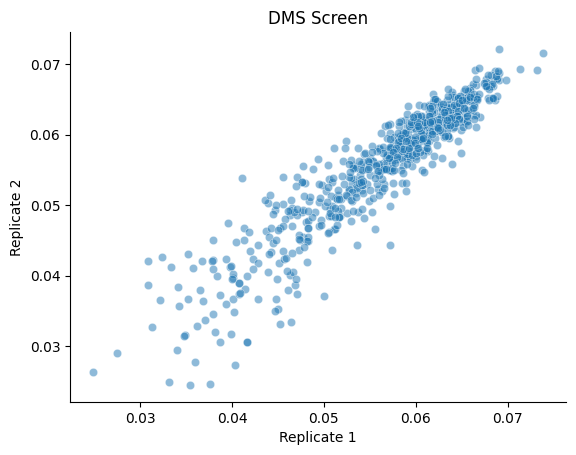

In [14]:
DMS_Rep = sns.scatterplot(x='Rep1', y='Rep2', alpha=0.5, data=DESeq2_Normed_Freq)
DMS_Rep.set(xlabel='Replicate 1', ylabel='Replicate 2',  title='DMS Screen')
sns.despine()
DMS_Rep.get_figure().savefig("DMS Screen Replicate Correlation.svg" , bbox_inches='tight', transparent=True) 

In [15]:
DESeq2_Normed_Freq[['Rep1', 'Rep2']].corr('spearman')

,Rep1,Rep2
Rep1,1.000000,0.940028
Rep2,0.940028,1.000000


In [16]:
Fitness = DeseqStats(dds, contrast=["Condition", "D6", "D0"])
Fitness.summary()

Running Wald tests...
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/ivan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip pa

Log2 fold change & Wald test p-value: Condition D6 vs D0
        baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
mut                                                                     
A269C  13.919916       -6.919236  1.852333 -3.735417  0.000187  0.005048
A269D  24.981732       -5.436859  1.987857 -2.735036  0.006237  0.026559
A269E  19.139214       -7.345459  1.801188 -4.078119  0.000045  0.002681
A269F  17.099118       -8.619537  2.849276 -3.025168  0.002485  0.019071
A269G  26.886086       -7.778994  1.805905 -4.307532  0.000017  0.001557
...          ...             ...       ...       ...       ...       ...
Y320N  15.367777        0.570454  1.157698  0.492748  0.622190  0.729388
Y320Q  11.662499       -0.469645  0.938736 -0.500295  0.616867  0.724435
Y320S  14.453690        0.571581  0.874560  0.653564  0.513393  0.636916
Y320T   9.151565       -1.947430  1.002333 -1.942897  0.052029  0.099968
Y320W  24.936634        0.630895  0.835402  0.755200  0.450129  0.5

... done in 0.86 seconds.



In [17]:
DMS = Fitness.results_df
DMS['growth_rate'] = np.log(np.power(2,DMS['log2FoldChange'])*2373)/144
DMS.to_csv('DMS_DF240603.csv')

In [18]:
#https://stackoverflow.com/questions/47971394/define-skewed-gaussian-function-that-returns-two-parameters-after-fitting
def skew(x, sigmag, mu, alpha, a):
    normpdf = (1 / (sigmag * np.sqrt(2 * math.pi))) * np.exp(-(np.power((x - mu), 2) / (2 * np.power(sigmag, 2))))
    normcdf = (0.5 * (1 + sp.erf((alpha * ((x - mu) / sigmag)) / (np.sqrt(2)))))
    return a * normpdf * normcdf

def two_skewed_guassians(x, sigmag1, mu1, alpha1, a1, sigmag2, mu2, alpha2, a2):
    return skew(x, sigmag1, mu1, alpha1, a1) + skew(x, sigmag2, mu2, alpha2, a2)


$$f(x) = a \left( \frac{1}{(\sigma_g \sqrt{2\pi})} \right) \exp \left( -\frac{(x - \mu)^2}{(2 \sigma_g^2)} \right) \left( 0.5 \left( 1 + \text{erf} \left( \alpha \frac{(x - \mu)}{(\sigma_g \sqrt{2})} \right) \right) \right)$$


In [19]:
#define bins
n_bins = 35
DMS_bins = DMS['growth_rate'].value_counts(bins=n_bins).reset_index()
DMS_bins['X'] = DMS_bins['index'].apply(lambda x: x.mid)

#fit two skewed gussians over the data
popt, pcov = curve_fit(two_skewed_guassians, DMS_bins['X'], DMS_bins['count'], 
                       p0=(0.01,0.02,2,1.5,0.1,0.06,1,1),
                       bounds=(0 ,[10,0.04,20,20,20,0.08,20,20]))

#fit lines
gr_space= np.linspace(0,0.08,400)
y_fit = two_skewed_guassians(gr_space, *popt)
left_gussain = skew(gr_space, *popt[:4])
right_gussain = skew(gr_space, *popt[4:])

In [20]:
popt

array([1.59940331e-02, 1.11681775e-02, 1.02315642e+01, 3.04557978e+00,
       5.55012446e-03, 5.58570426e-02, 8.85262693e-06, 2.37904373e+00])

In [21]:
SD2 = popt[5] - 2*popt[4]
SD4 = popt[5] - 4*popt[4]

In [22]:
SD2 , SD4

(0.04475679365950399, 0.03365654474855129)

In [23]:
sns.set_context("paper")

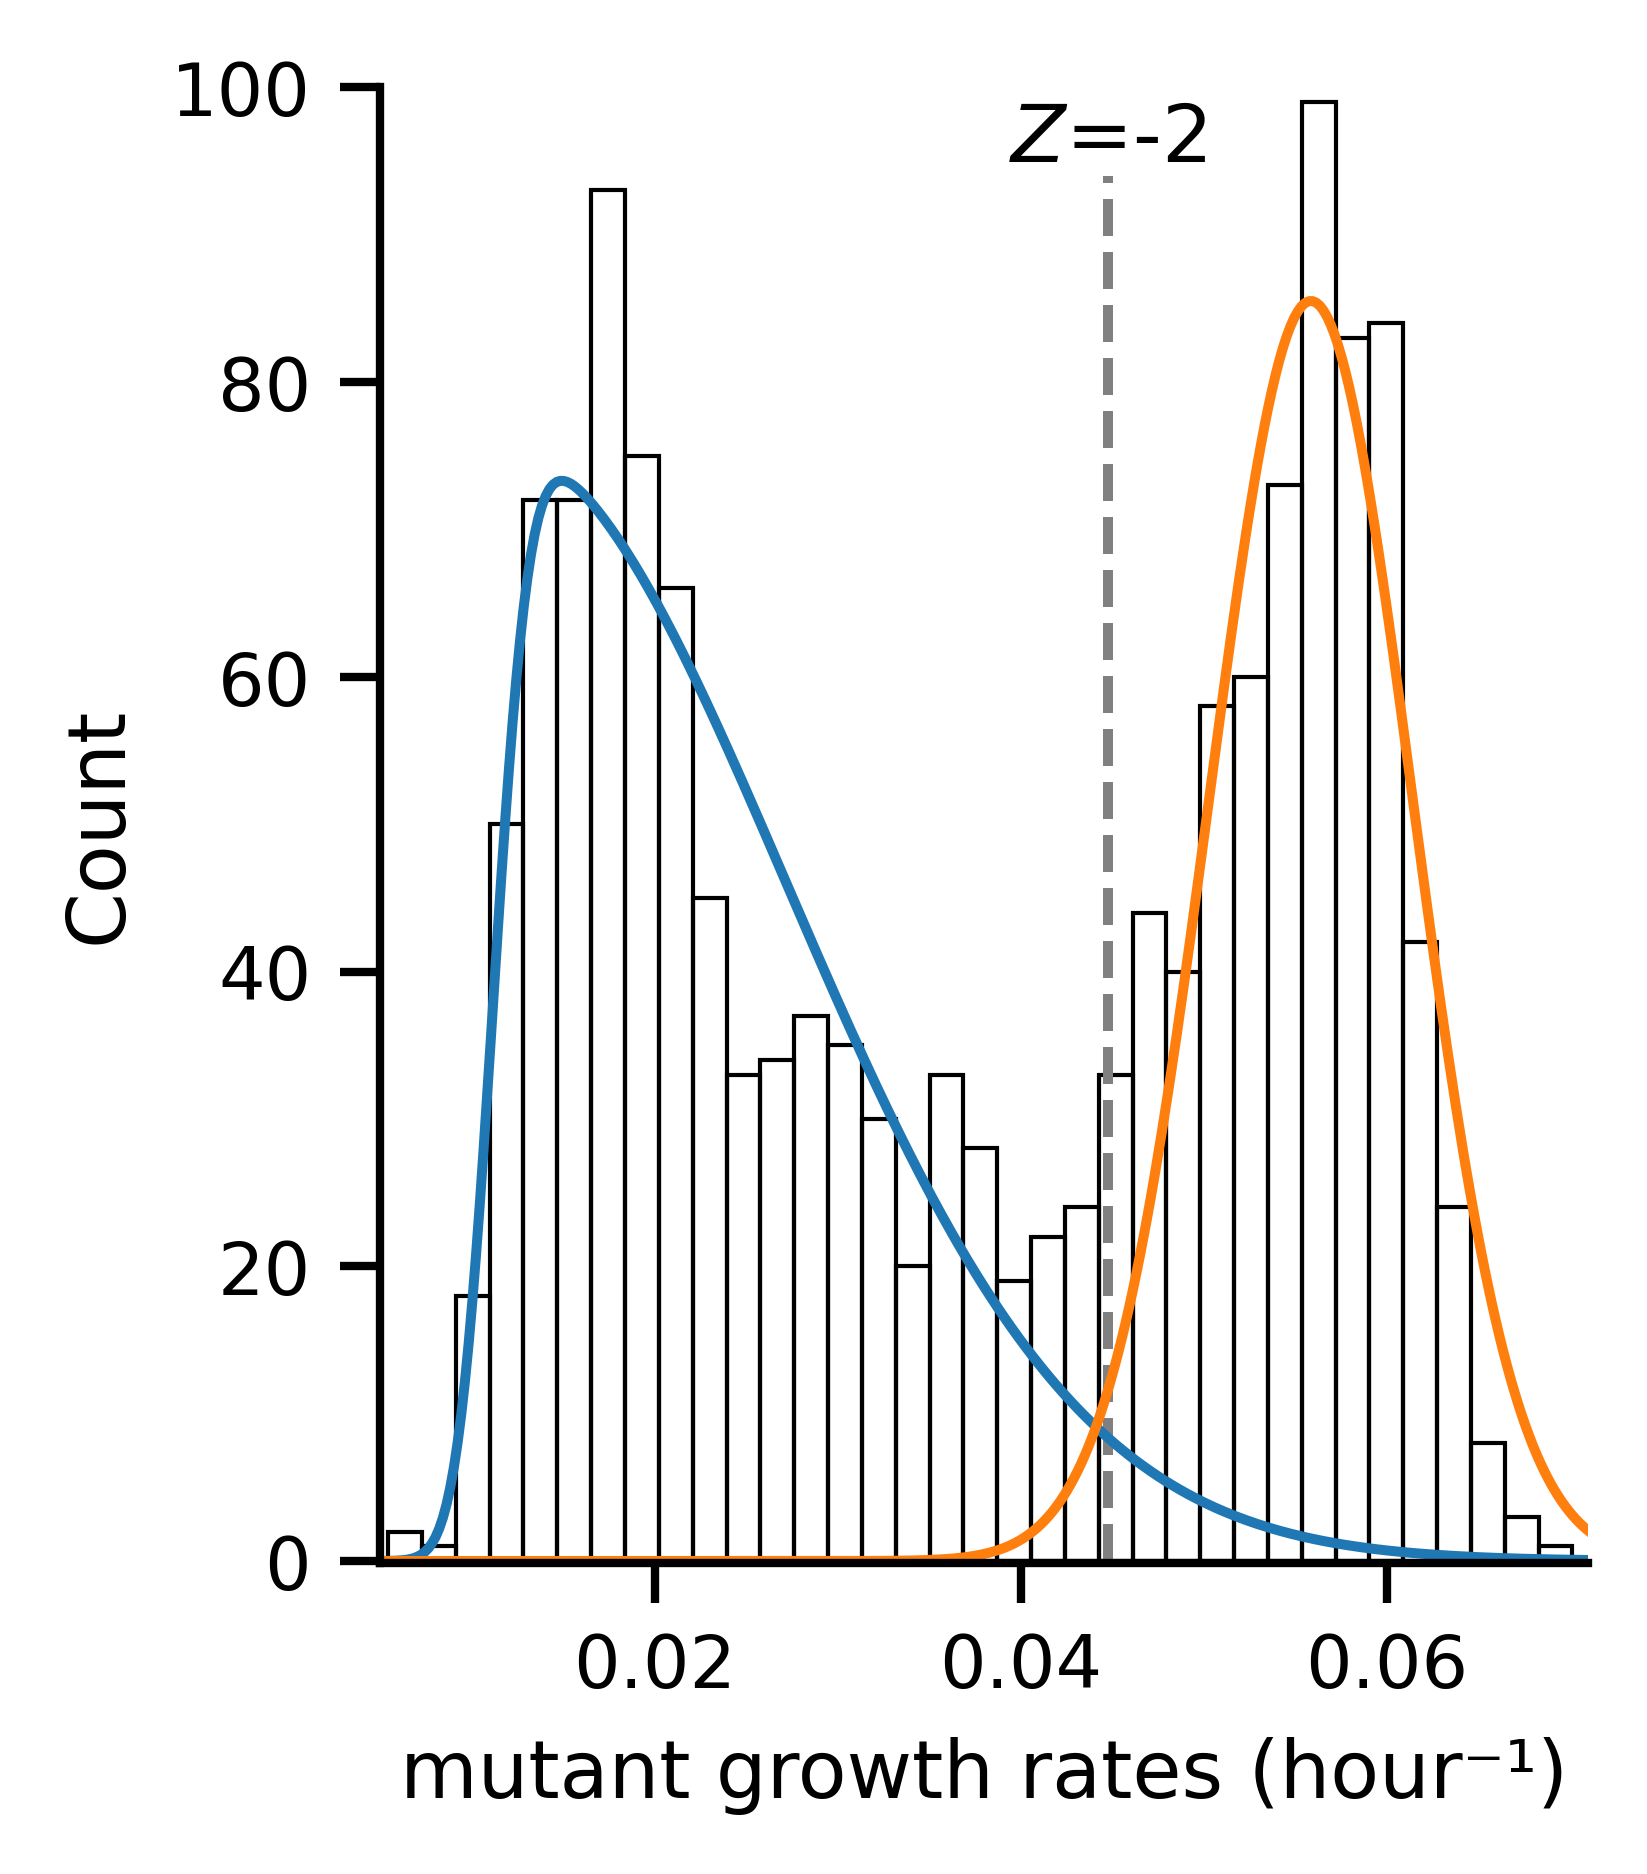

In [24]:
#plt.figure(figsize=(4,4), dpi=600)
plt.figure(figsize=(1.2*60*0.0393701,1.2*68*0.0393701), dpi=600)
hist_gr = sns.histplot(x='growth_rate', data=DMS, bins=n_bins, color='black', fill=False,  edgecolor='red')
hist_gr.set(xlim=[0.005, 0.071], ylim=[-.1,100], xlabel='mutant growth rates (hour⁻¹)')
hist_gr.text(SD2, 95, '$\it{Z}$=-2', ha='center')
plt.vlines(SD2, 0,94, linestyles="--", color='grey')
sns.lineplot(x=gr_space, y=left_gussain)
sns.lineplot(x=gr_space, y=right_gussain)
sns.despine(bottom=False, left=False, right=True, top=True)
plt.tight_layout()
hist_gr.get_figure().savefig("DMS Distribution 250613.svg", transparent=True) 

## Making Heatmap

In [25]:
DMS = DMS.reset_index()

In [26]:
DMS['WT_AA'] = DMS['mut'].str[0]
DMS['mut_AA'] = DMS['mut'].str[-1]
DMS['position'] = DMS['mut'].str[1:-1].astype(int)
DMS2 = DMS.loc[DMS['position'].between(242,320),['WT_AA', 'mut_AA', 'position', 'growth_rate']]

### What perent of DMS variatns are delaterious (growth rate < Z=-2)?

In [27]:
len(DMS2)

1441

In [28]:
(DMS2['growth_rate'] < SD2).sum()/len(DMS2)

0.5579458709229702

In [29]:
DMS.loc[DMS['position']==271, 'growth_rate'].mean()

0.018880614841803135

Mean growth rate of AA variants at a key functional residue (K271) is 0.019

In [30]:
(DMS.loc[DMS['position'].between(242, 320), 'growth_rate'] < SD2).sum() / (DMS.loc[DMS['position'].between(242, 320), 'growth_rate'] < SD2).count()

0.5579458709229702

About 56% of mutants are delaterious.

In [31]:
WT_DMS = DMS2[['WT_AA', 'mut_AA', 'position', 'growth_rate']]
WT_DMS['mut_AA'] = WT_DMS['WT_AA']
WT_DMS['growth_rate'] = popt[5] # WT growth rate from fit
WT_DMS = WT_DMS.drop_duplicates()

In [32]:
DMS_WT_DF = pd.concat([DMS2,WT_DMS])

In [33]:
DMS_WT_DF.to_csv('DMS_GrowthRates.csv')

In [34]:
DMS_PV = pd.pivot_table(DMS_WT_DF, values='growth_rate', index='mut_AA', columns='position')

In [35]:
WT_PV = pd.pivot_table(WT_DMS, values='growth_rate', index='mut_AA', columns='position')

In [36]:
WT_PV2 = WT_PV.fillna('').replace(popt[5], '•')

In [37]:
#sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_context('paper')

In [38]:
Fowler_AA_order = ['H', 'K', 'R', 'D', 'E', 'C', 'M', 'N', 'Q', 'S', 'T',
           'A', 'I', 'L', 'V', 'F', 'W', 'Y','G', 'P']
Ivan_AA_order = ['K', 'R', 'D', 'E', 'C', 'M', 'N', 'Q', 'S', 'T',
           'A', 'I', 'L', 'V', 'F', 'H', 'W', 'Y','G', 'P']
Justin_AA_order = ['K', 'R', 'D', 'E', 'C', 'M', 'N', 'Q', 'S', 'T',
           'A', 'I', 'L', 'V', 'P', 'F', 'W', 'Y', 'H','G']

In [39]:
DMS_PV = DMS_PV.reindex(index=Justin_AA_order)
WT_PV2 = WT_PV2.reindex(index=Justin_AA_order)

## Conservation Heatmap

In [40]:
consurf_grades = pd.read_csv('6xr6_consurf_grades.txt', delimiter='\t', skiprows=27,  skipfooter=2)
consurf_grades['AA'] = range(229, 229 + 287, 1)
consurf_grades = consurf_grades.loc[consurf_grades['AA'].between(242,320)]

/tmp/ipykernel_133990/1240476926.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  consurf_grades = pd.read_csv('6xr6_consurf_grades.txt', delimiter='\t', skiprows=27,  skipfooter=2)


In [41]:
buried_dict = {'b':1, 'e':0}
consurf_grades['B/E'] = consurf_grades['B/E'].str[-1:] #remove space in string
consurf_grades['buried'] = consurf_grades['B/E'].map(buried_dict)

In [42]:
consurf_grades['B/E'].values

array(['b', 'e', 'b', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'b', 'b',
       'e', 'b', 'e', 'e', 'b', 'e', 'b', 'e', 'e', 'e', 'e', 'e', 'e',
       'b', 'b', 'b', 'e', 'e', 'b', 'e', 'e', 'e', 'e', 'e', 'e', 'e',
       'e', 'e', 'b', 'b', 'e', 'e', 'b', 'e', 'b', 'b', 'e', 'e', 'b',
       'e', 'e', 'e', 'e', 'b', 'b', 'e', 'b', 'b', 'b', 'b', 'b', 'e',
       'e', 'e', 'e', 'e', 'b', 'b', 'b', 'b', 'b', 'e', 'b', 'b', 'e',
       'e'], dtype=object)

In [43]:
consurf_exposure_annotation = consurf_grades[['AA', 'B/E']].set_index('AA').T
consurf_exposure_value = consurf_grades[['AA', 'buried']].set_index('AA').T

In [44]:
consurf_exposure_value

AA,242,243,244,245,246,247,248,249,250,251,...,311,312,313,314,315,316,317,318,319,320
buried,1,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,1,0,0


In [45]:
from matplotlib.colors import LinearSegmentedColormap
cmap_binary = LinearSegmentedColormap.from_list('Custom', ["Red", "Blue"] , 2)

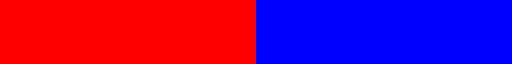

In [46]:
cmap_binary

In [47]:
ConSurf = pd.read_csv('msa_aa_variety_percentage.csv', skiprows=4)
ConSurf['AA'] = range(229, 229 + 287, 1)

Justin_Order_Cons = ['K', 'R', 'D', 'E', 'C', 'M', 'N', 'Q', 'S', 'T',
           'A', 'I', 'L', 'V', 'P', 'F', 'W', 'Y', 'H','G', 'AA' ]
ConSurf2 = ConSurf.loc[ConSurf['AA'].between(242,320), Justin_Order_Cons].set_index('AA').T
ConSurf_Con = ConSurf.loc[ConSurf['AA'].between(242,320), ['AA','ConSurf grade']].set_index('AA').T

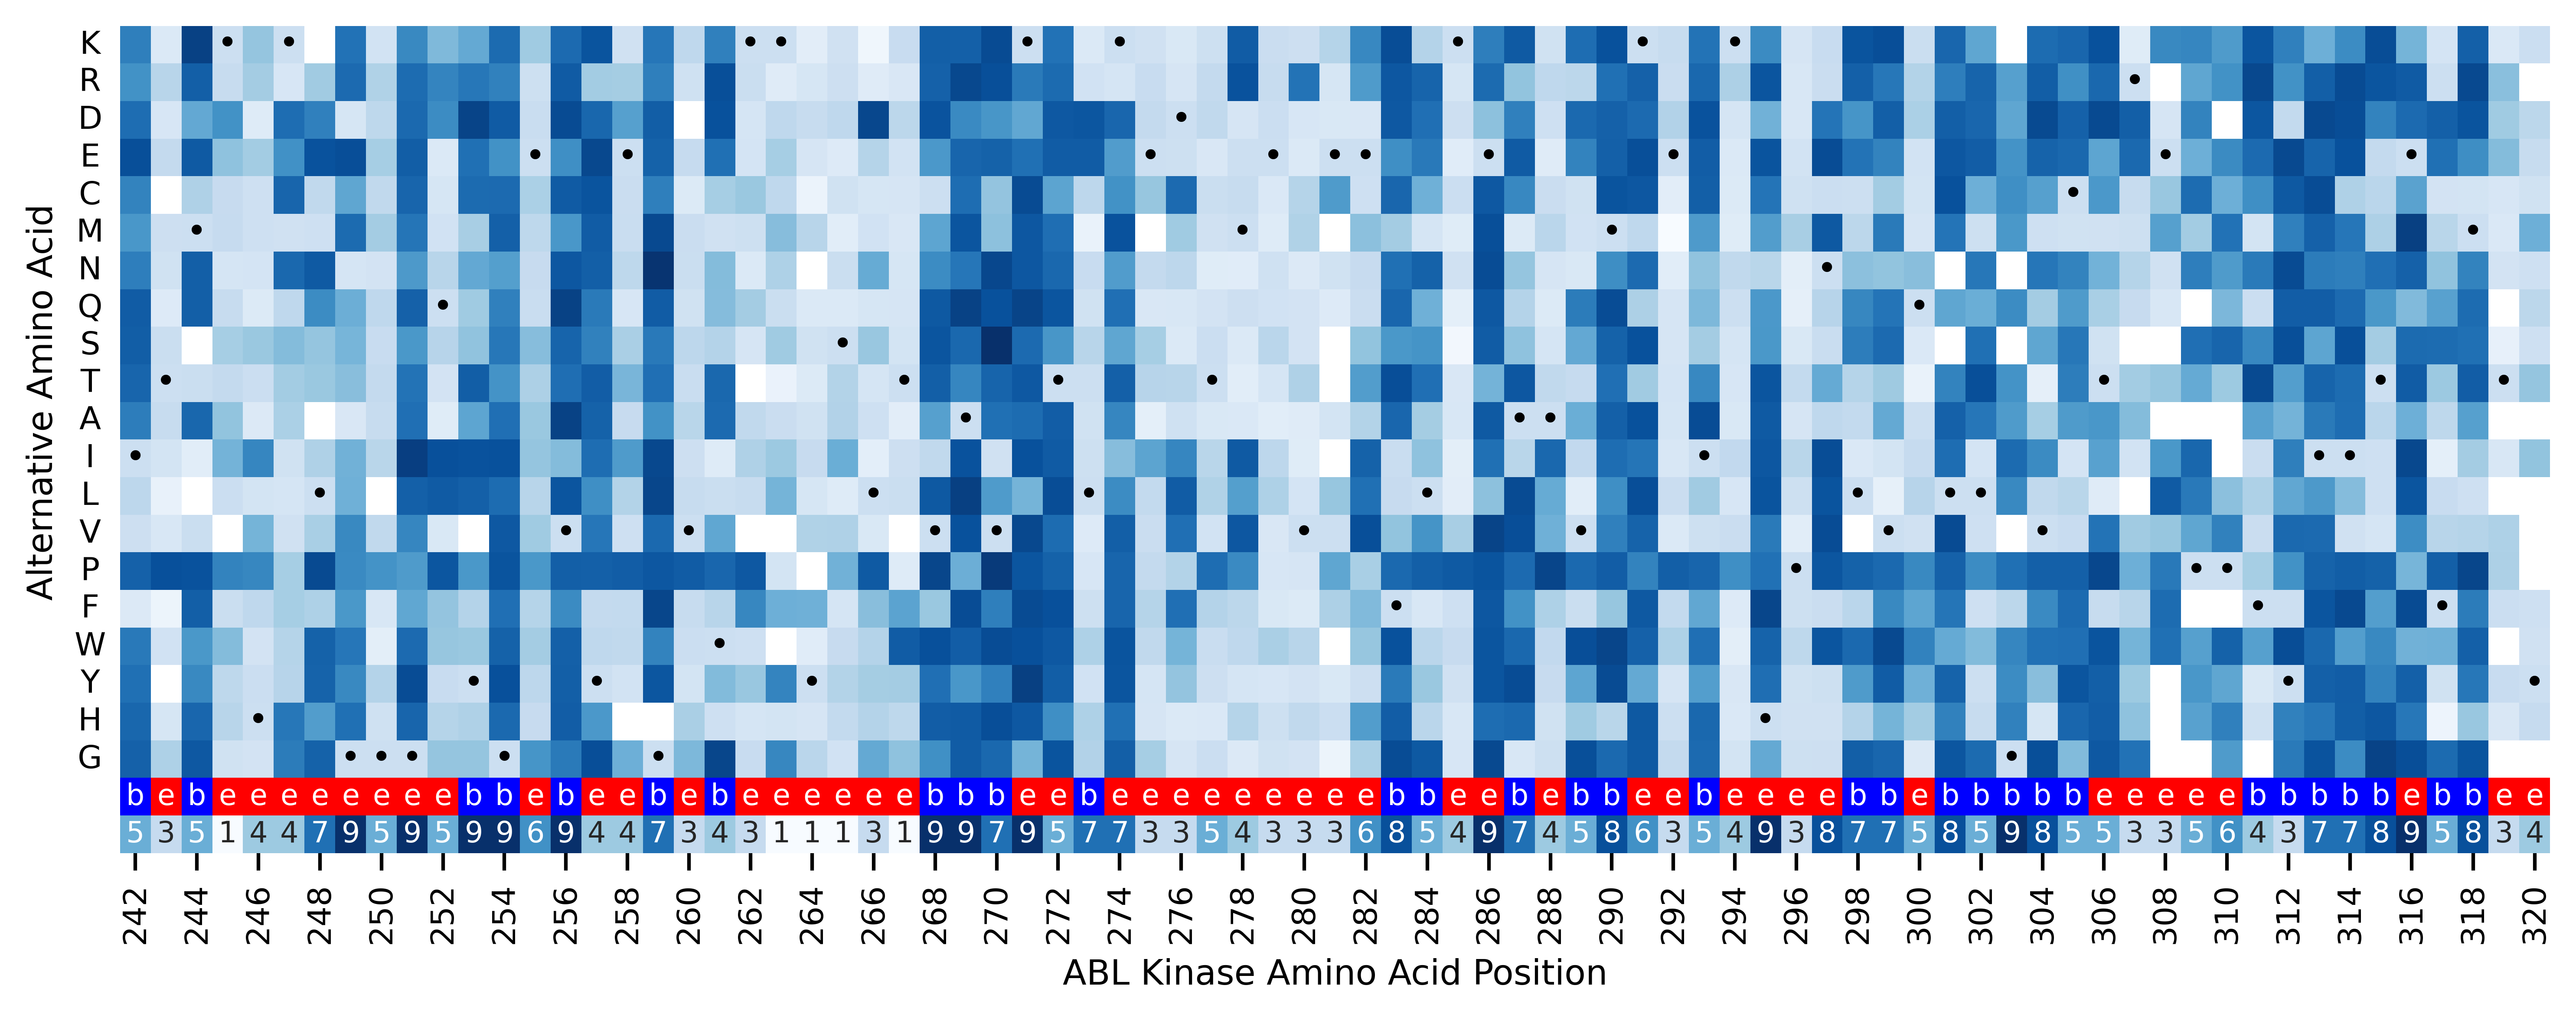

In [48]:
f, axs = plt.subplots(3, 1, figsize=(10,4), dpi=600, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': [20, 1, 1]})

DMS_heatmap = sns.heatmap(DMS_PV, annot=WT_PV2, fmt='', annot_kws={'color':'Black'}, cmap='Blues_r', ax=axs[0], yticklabels=True, cbar=False)
DMS_heatmap.set_yticklabels(labels=DMS_heatmap.get_yticklabels(), rotation=0, ha="center")
DMS_heatmap.set(xlabel=None, ylabel='Alternative Amino Acid',)
DMS_heatmap.tick_params(left=False)

exposure = sns.heatmap(consurf_exposure_value, annot=consurf_exposure_annotation, cmap=cmap_binary, annot_kws={"fontsize":8}, fmt = '', ax=axs[1], yticklabels='', cbar=False)
exposure.set(xlabel=None, ylabel=None)


Con = sns.heatmap(ConSurf_Con, ax=axs[2], annot=True, cmap='Blues',annot_kws={"fontsize":8}, cbar=False, yticklabels=False)
Con.set(xlabel='ABL Kinase Amino Acid Position', ylabel=None)

plt.tight_layout()
DMS_heatmap.get_figure().savefig("DMS Heatmap 240612 Blues ConSurf2.svg", transparent=True) 

In [49]:
mappable = DMS_heatmap.get_children()[0]
plt.colorbar(mappable, ax=axs[0], location='right')

/tmp/ipykernel_133990/2965452055.py:2: UserWarning: Adding colorbar to a different Figure <Figure size 6000x2400 with 4 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(mappable, ax=axs[0], location='right')


<Figure size 640x480 with 0 Axes>

In [50]:
DMS_heatmap.get_children()[0]

# Conservation Correlation

In [51]:
Mean_DMS = DMS2[['position', 'growth_rate']].groupby('position').mean().reset_index()
DMS_Mean_Cons = pd.merge(Mean_DMS, consurf_grades, left_on='position', right_on='AA')

In [52]:
DMS_Mean_Cons['Conservation'] = DMS_Mean_Cons['COLOR'].astype(int)
buried_dict = {'b':'buried', 'e':'exposed'}

In [53]:
DMS_Mean_Cons['Surf'] = DMS_Mean_Cons['B/E'].map(buried_dict)

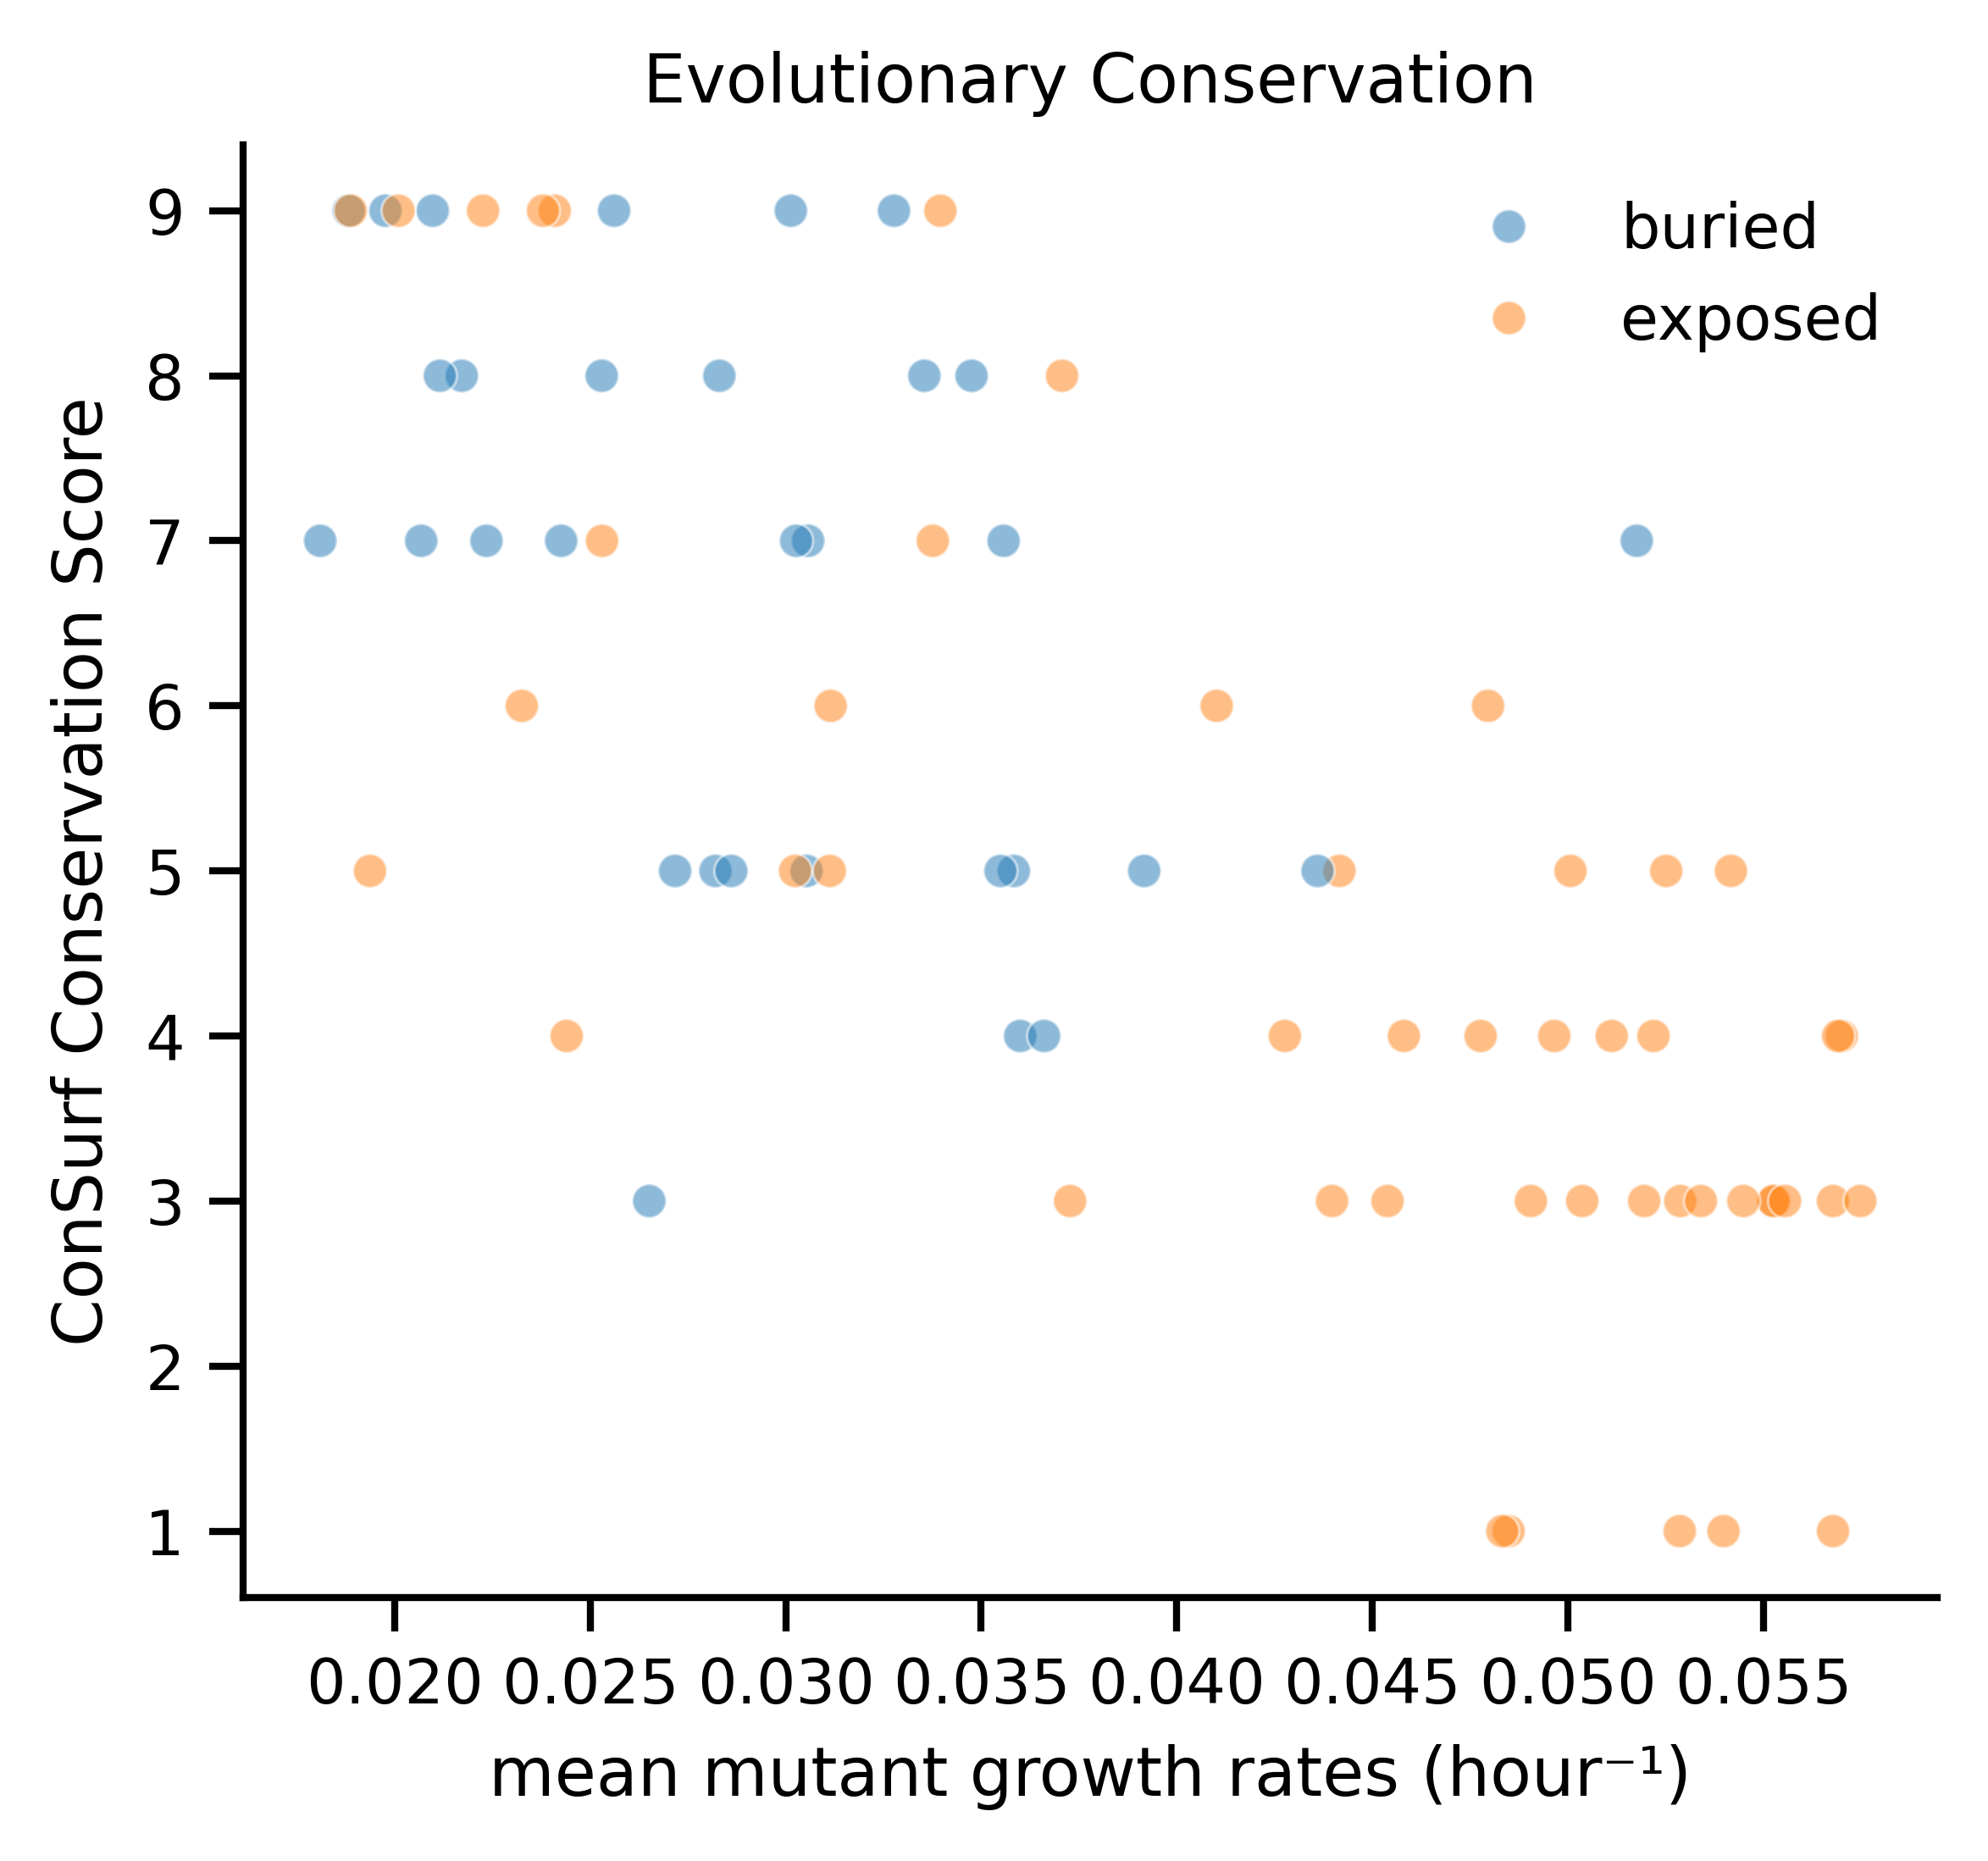

In [54]:
plt.figure(figsize=(4,3.75), dpi=600)
cons_corr = sns.scatterplot(x='growth_rate', y='Conservation', hue='Surf', alpha=0.5, data=DMS_Mean_Cons)
cons_corr.set(xlabel='mean mutant growth rates (hour⁻¹)', ylabel='ConSurf Conservation Score', title='Evolutionary Conservation')
sns.despine()
plt.tight_layout()
plt.legend(frameon=False)
cons_corr.get_figure().savefig("EvolutionaryConservation.svg" , transparent=True) 

In [55]:
DMS_Mean_Cons[['growth_rate', ' SCORE']].corr()

,growth_rate,SCORE
growth_rate,1.000000,0.738662
SCORE,0.738662,1.000000


In [56]:
from scipy.stats import pearsonr

In [57]:
pearsonr(DMS_Mean_Cons['growth_rate'], DMS_Mean_Cons[' SCORE'])

PearsonRResult(statistic=0.7386622257851818, pvalue=7.851317909533599e-15)

In [58]:
DMS_Mean_Cons['DMS_Dropout'] = DMS_Mean_Cons['growth_rate'] < SD2

In [59]:
pd.crosstab(DMS_Mean_Cons['buried'], DMS_Mean_Cons['DMS_Dropout'])

DMS_Dropout,False,True
buried,,
0,28,20
1,1,30


In [60]:
fisher_exact(pd.crosstab(DMS_Mean_Cons['DMS_Dropout'], DMS_Mean_Cons['buried']), alternative='greater')

SignificanceResult(statistic=42.0, pvalue=1.5941780297419684e-07)

In [61]:
import statsmodels.api as sm

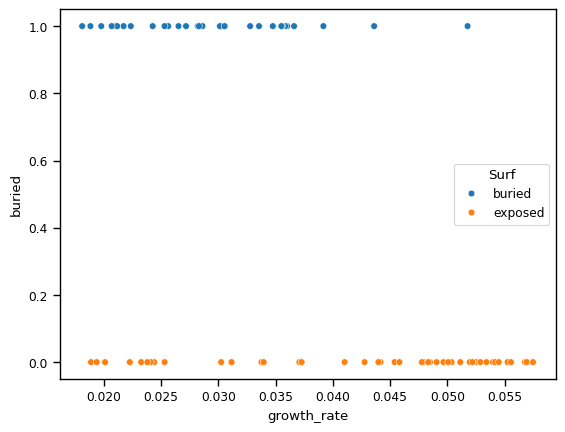

In [62]:
cons_corr = sns.scatterplot(x='growth_rate', y='buried', hue='Surf', data=DMS_Mean_Cons)

In [63]:
pearsonr(DMS_Mean_Cons['buried'],DMS_Mean_Cons['growth_rate'])

PearsonRResult(statistic=-0.5280348710230178, pvalue=5.702319239222555e-07)

In [64]:
sm.Logit(DMS_Mean_Cons['buried'],DMS_Mean_Cons['growth_rate']).fit().summary()

Optimization terminated successfully.
         Current function value: 0.623348
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 buried   No. Observations:                   79
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            0
Date:                Mon, 07 Jul 2025   Pseudo R-squ.:                 0.06937
Time:                        22:29:36   Log-Likelihood:                -49.244
converged:                       True   LL-Null:                       -52.915
Covariance Type:            nonrobust   LLR p-value:                       nan
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
growth_rate   -19.7211      6.244     -3.159      0.002     -31.959      -7.484
===============================================================================
"""

Both pearson and logistic regresion confirm that buried residues tend to deplete. 